In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib.ticker as ticker
from pandas.plotting import table
import imgkit

from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from IPython.display import display, Markdown

ModuleNotFoundError: No module named 'imgkit'

In [2]:
df = pd.read_csv("../lego.population.csv", sep = ",", encoding = "latin1")

In [3]:
# Rensking av datasett
df2 = df[['Set_Name', 'Theme', 'Pieces', 'Price', 'Pages', 'Minifigures', 'Unique_Pieces', 'Ages']]
df2 = df2.dropna()
df2['Theme'] = df2['Theme'].astype(str).str.replace(r'[^a-zA-Z0-9\s-]', '', regex = True)
df2['Price'] = df2['Price'].str.replace('\$', '', regex = True).astype(float)

#df2 = df2[~df2['Ages'].str.contains('Ages_2')]
#df2 = df2[~df2['Ages'].str.contains('Ages_1½')]
df = False

# 1. Bli kjent med dataene

## Scatterplot av alle mulige forklaringsvariabler

### Pages

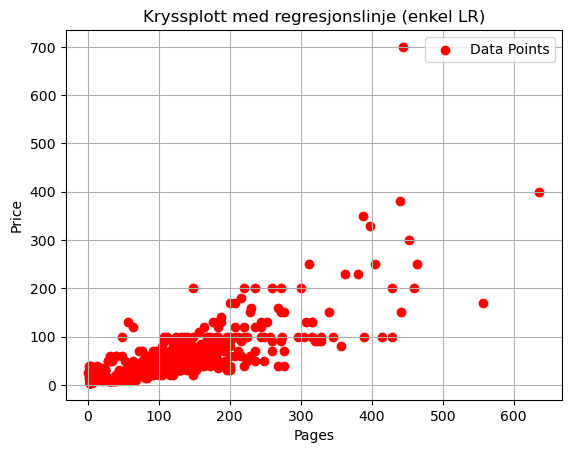

### Pieces

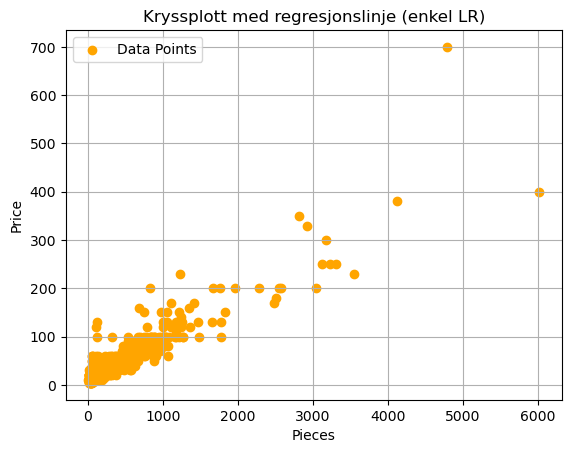

### Unique_Pieces

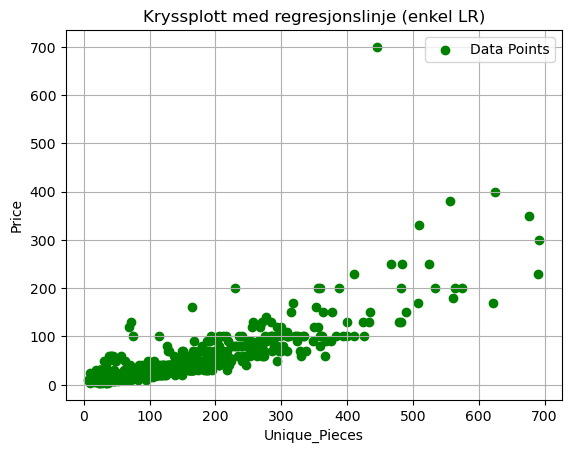

### Minifigures

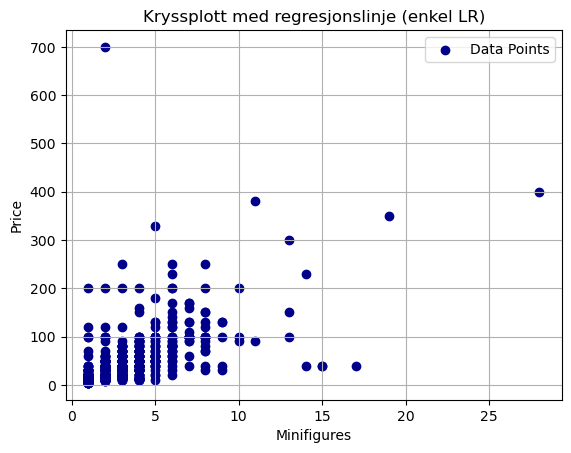

In [4]:
# Scatterplot av alle variabler
colors=['red', 'orange', 'green', 'darkblue']

for i, field in enumerate(["Pages", "Pieces", "Unique_Pieces", "Minifigures"]):
    display(Markdown(f"### {field}"))
    plt.scatter(df2[field], df2['Price'], label='Data Points', color=colors[i])
    plt.xlabel(field)
    plt.ylabel('Price')
    plt.title('Kryssplott med regresjonslinje (enkel LR)')
    plt.legend()
    plt.grid()
    plt.savefig(f'{field}-scatterplot.png')
    plt.show()


## Dyreste brikker, dyreste sider

## Sorted by Price per Pieces

,Set_Name,Theme,Pieces,Price,Pages,Minifigures,Unique_Pieces,Ages,Price_Per_Pieces,Price_Per_Pages,Price_Per_Unique_Pieces
550,Ocean's Bottom,Classic,579.0,29.99,57.0,2.0,218.0,Ages_5-99,0.051796,0.526140,0.137569
335,Formula E Panasonic Jaguar Racing GEN2 Car & J...,Speed Champions,565.0,29.99,128.0,2.0,186.0,Ages_8+,0.053080,0.234297,0.161237
1074,Diagon Alley,Harry Potter,374.0,19.99,72.0,1.0,116.0,Ages_10+,0.053449,0.277639,0.172328
1043,Fun Future,Classic,186.0,9.99,49.0,1.0,95.0,Ages_5-99,0.053710,0.203878,0.105158
586,Central Perk,Ideas,1070.0,59.99,156.0,7.0,366.0,Ages_16+,0.056065,0.384551,0.163907
...,...,...,...,...,...,...,...,...,...,...,...
1001,Wrecking Ball Demolition,DUPLO,56.0,59.99,32.0,3.0,41.0,Ages_2+,1.071250,1.874688,1.463171
742,Cargo Train,DUPLO,105.0,119.99,64.0,3.0,68.0,Ages_2-5,1.142762,1.874844,1.764559
157,Elsa and Olaf's Tea Party,DUPLO,17.0,19.99,12.0,2.0,13.0,Ages_2+,1.175882,1.665833,1.537692
24,Police Bike,DUPLO,8.0,9.99,10.0,1.0,7.0,Ages_2+,1.248750,0.999000,1.427143


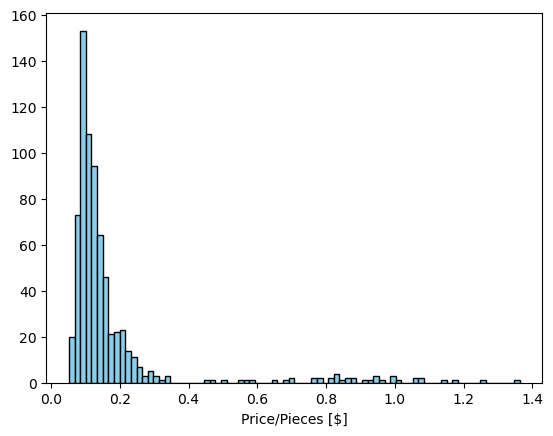

## Sorted by Price per Pages

,Set_Name,Theme,Pieces,Price,Pages,Minifigures,Unique_Pieces,Ages,Price_Per_Pieces,Price_Per_Pages,Price_Per_Unique_Pieces
412,Outback Adventures,Creator 3-in-1,225.0,19.99,148.0,1.0,103.0,Ages_7-12,0.088844,0.135068,0.194078
436,Space Rover Explorer,Creator 3-in-1,510.0,39.99,276.0,1.0,206.0,Ages_8+,0.078412,0.144891,0.194126
53,Spider-Man Mech,Marvel,152.0,9.99,68.0,1.0,62.0,Ages_6+,0.065724,0.146912,0.161129
435,Townhouse Toy Store,Creator 3-in-1,554.0,39.99,268.0,2.0,194.0,Ages_8+,0.072184,0.149216,0.206134
314,Race Plane,Creator 3-in-1,333.0,29.99,200.0,1.0,134.0,Ages_7+,0.090060,0.149950,0.223806
...,...,...,...,...,...,...,...,...,...,...,...
426,Star Wars Advent Calendar,Star Wars,307.0,39.99,4.0,7.0,186.0,Ages_6-14,0.130261,9.997500,0.215000
477,Harry Potter Advent Calendar,Harry Potter,305.0,39.99,3.0,8.0,151.0,Ages_7+,0.131115,13.330000,0.264834
400,Friends Advent Calendar,Friends,330.0,29.99,2.0,3.0,158.0,Ages_6+,0.090879,14.995000,0.189810
504,Star Wars Advent Calendar,Star Wars,280.0,39.99,2.0,9.0,177.0,Ages_6+,0.142821,19.995000,0.225932


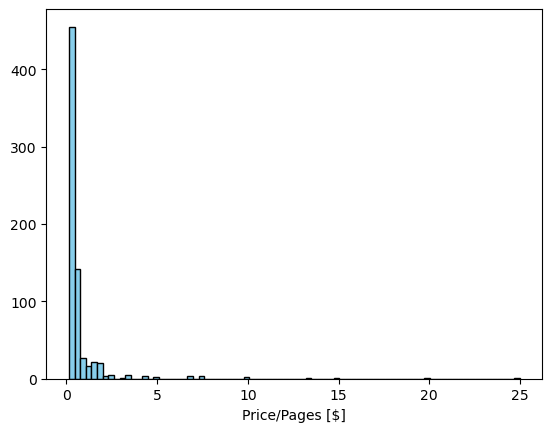

## Sorted by Price per Unique_Pieces

,Set_Name,Theme,Pieces,Price,Pages,Minifigures,Unique_Pieces,Ages,Price_Per_Pieces,Price_Per_Pages,Price_Per_Unique_Pieces
1043,Fun Future,Classic,186.0,9.99,49.0,1.0,95.0,Ages_5-99,0.053710,0.203878,0.105158
848,Police Water Plane,City,48.0,3.99,3.0,1.0,36.0,Ages_5-12,0.083125,1.330000,0.110833
849,Arctic Ice Saw,City,43.0,3.99,3.0,1.0,34.0,Ages_5-12,0.092791,1.330000,0.117353
42,Unikitty Cloud Car,Unikitty,126.0,9.99,60.0,3.0,83.0,Ages_5-12,0.079286,0.166500,0.120361
846,Road Worker,City,58.0,3.99,3.0,1.0,33.0,Ages_5-12,0.068793,1.330000,0.120909
...,...,...,...,...,...,...,...,...,...,...,...
469,Frozen Ice Castle,Disney,59.0,49.99,28.0,3.0,31.0,Ages_2+,0.847288,1.785357,1.612581
528,T. rex Tower,Jurassic World,22.0,29.99,14.0,1.0,18.0,Ages_2-5,1.363182,2.142143,1.666111
742,Cargo Train,DUPLO,105.0,119.99,64.0,3.0,68.0,Ages_2-5,1.142762,1.874844,1.764559
1048,Tower Crane & Construction,DUPLO,123.0,129.99,56.0,5.0,72.0,Ages_2+,1.056829,2.321250,1.805417


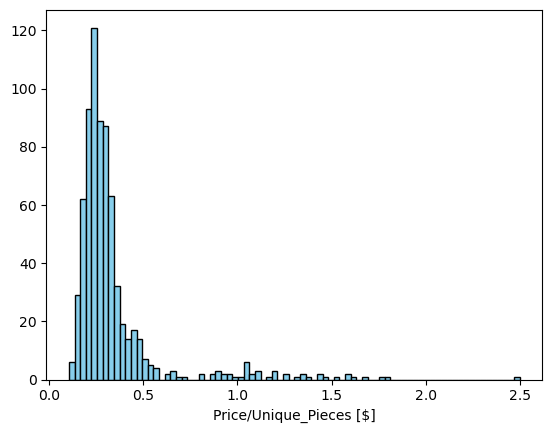

In [5]:
fields = ["Pieces", "Pages", "Unique_Pieces"]

for field in fields:
    df2[f"Price_Per_{field}"] = df2['Price'] / df2[field]

for field in fields:
    display(Markdown(f'## Sorted by Price per {field}'))
    display(df2.sort_values(f'Price_Per_{field}'))
    
    plt.hist(df2[f'Price_Per_{field}'], bins=80, color='skyblue', edgecolor='black')
    plt.xlabel(f'Price/{field} [$]')
    
#    plt.yscale('log')
#    y_ax = plt.gca().yaxis
#    y_ax.set_major_locator(ticker.FixedLocator([1, 10, 100, 1000]))
#    y_ax.set_major_formatter(ticker.ScalarFormatter())
    
    plt.ylabel('')
    #plt.gca().set_aspect(1)
    plt.savefig(f'Price-per-{field}-log-scale.png')
    plt.show()


# 2. Spesifisere en matematisk modell

Vi ser en trend i `Pieces`, `Pages`, og `Unique_Pieces` ift. pris. Variasjonene i disse ser noe normalfordelt ut i log-skala. Vi prøver enkel lineær regresjon med disse.

### Pages

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     1177.
Date:                Fri, 17 Nov 2023   Prob (F-statistic):          4.85e-153
Time:                        19:59:21   Log-Likelihood:                -3505.1
No. Observations:                 714   AIC:                             7014.
Df Residuals:                     712   BIC:                             7023.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.4203      1.901     -1.799      0.072      -7.153       0.312
Pages          0.4820      0.014     34.314      0.000       0.454       0.510
==============================================================================
Omnibus:                      831.547   Durbin-Watson:                   1.389
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           155473.051
Skew:                           5.307   Prob(JB):                         0.00
Kurtosis:                      74.508   Cond. No.                         209.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

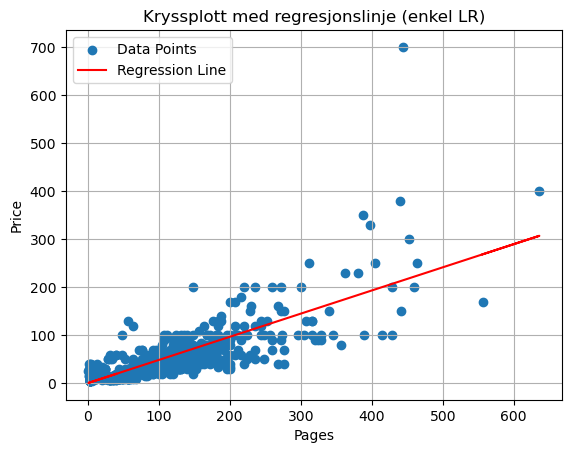

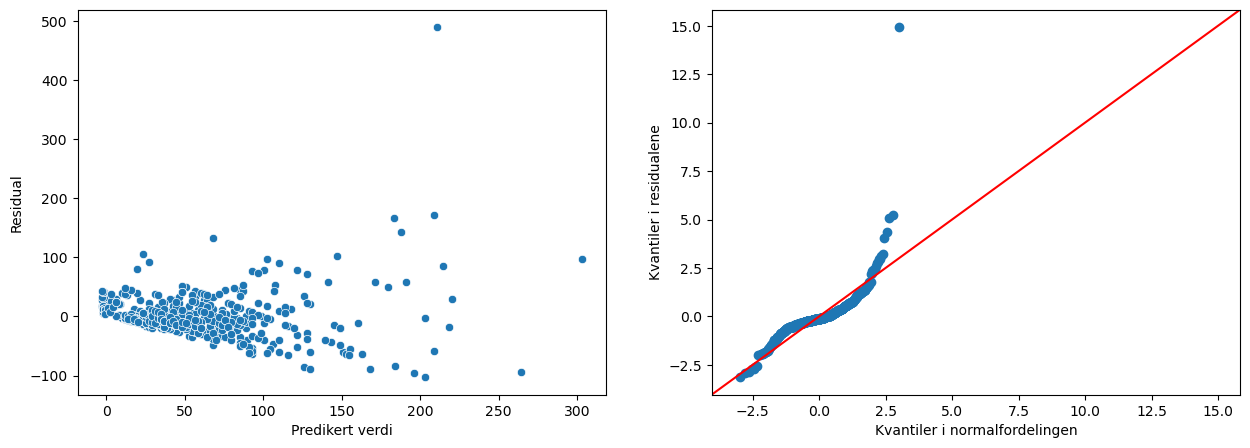

### Pieces

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     3802.
Date:                Fri, 17 Nov 2023   Prob (F-statistic):          9.01e-288
Time:                        19:59:21   Log-Likelihood:                -3194.2
No. Observations:                 714   AIC:                             6392.
Df Residuals:                     712   BIC:                             6401.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.2338      0.988     10.363      0.000       8.295      12.173
Pieces         0.0873      0.001     61.664      0.000       0.085       0.090
==============================================================================
Omnibus:                      659.458   Durbin-Watson:                   1.774
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            61214.067
Skew:                           3.717   Prob(JB):                         0.00
Kurtosis:                      47.748   Cond. No.                         866.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

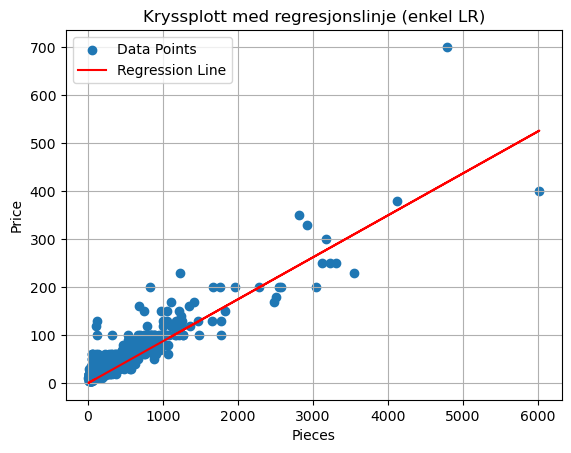

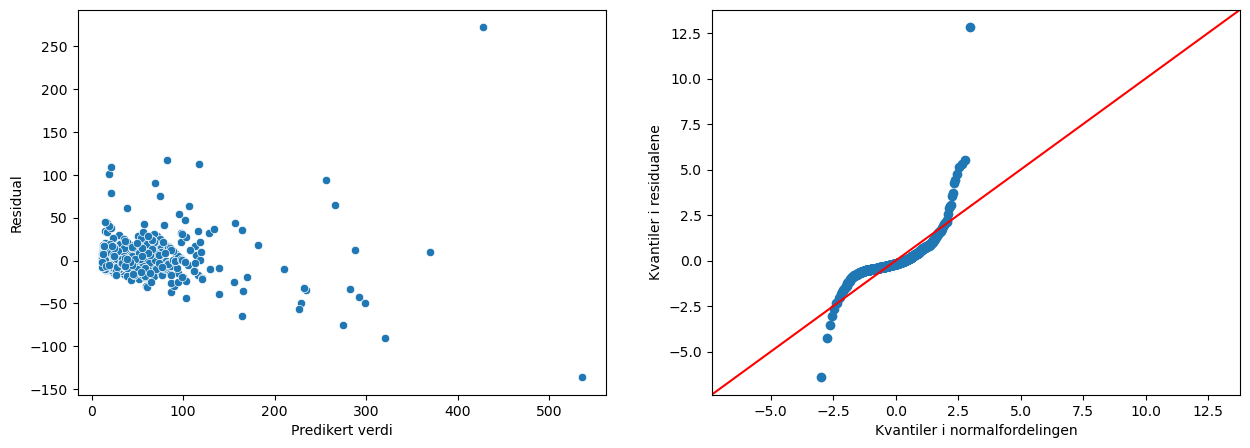

### Unique_Pieces

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     1404.
Date:                Fri, 17 Nov 2023   Prob (F-statistic):          1.39e-170
Time:                        19:59:22   Log-Likelihood:                -3464.7
No. Observations:                 714   AIC:                             6933.
Df Residuals:                     712   BIC:                             6942.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -8.8861      1.877     -4.735      0.000     -12.570      -5.202
Unique_Pieces     0.3818      0.010     37.473      0.000       0.362       0.402
==============================================================================
Omnibus:                     1081.739   Durbin-Watson:                   1.624
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           515276.524
Skew:                           8.403   Prob(JB):                         0.00
Kurtosis:                     133.529   Cond. No.                         298.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

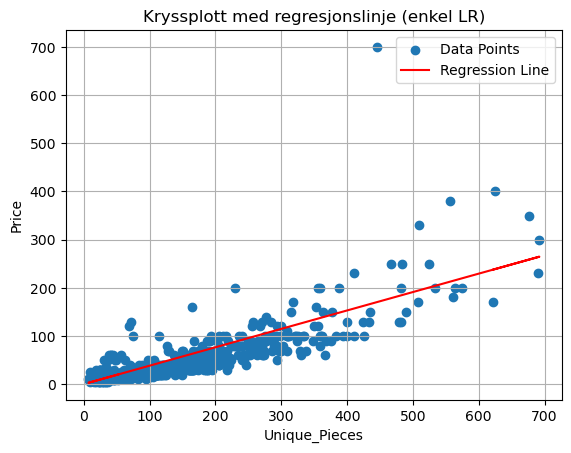

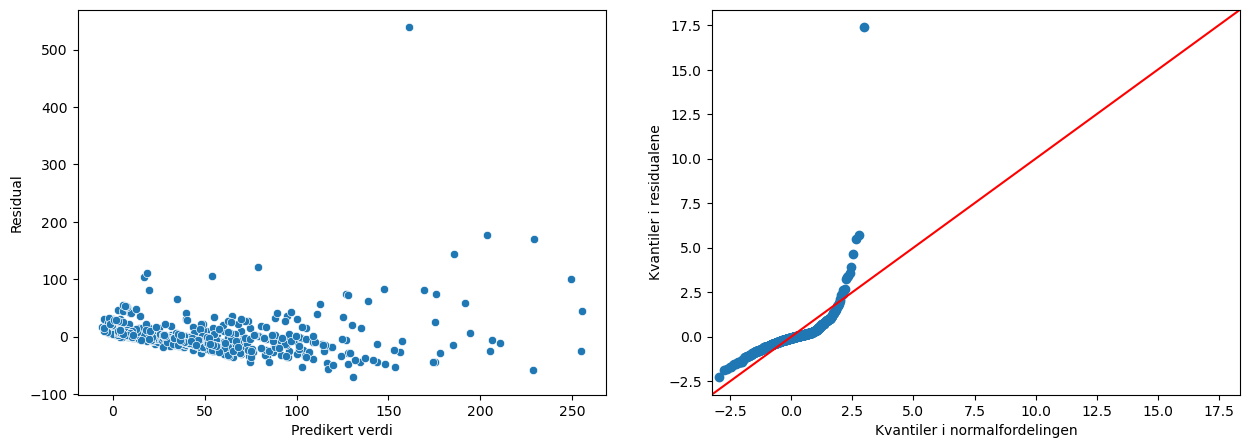

In [6]:

for field in ["Pages", "Pieces", "Unique_Pieces"]:
    model4a = smf.ols(f"Price ~ {field}", data = df2)
    fit = model4a.fit()

    display(Markdown(f"### {field}"))
    display(fit.summary())

    regression_x = np.array(df2[field])
    regression_y = fit.params[field] * regression_x + fit.params[field]
    
    plt.scatter(df2[field], df2['Price'], label='Data Points')
    plt.plot(regression_x, regression_y, color='red', label='Regression Line')
    plt.xlabel(field)
    plt.ylabel('Price')
    plt.title('Kryssplott med regresjonslinje (enkel LR)')
    plt.legend()
    plt.grid()
    plt.savefig(f"regression-scatterplot-{field}.png")
    plt.show()

    figure, axis = plt.subplots(1, 2, figsize = (15, 5))
    sns.scatterplot(x = fit.fittedvalues, y = fit.resid, ax = axis[0])
    axis[0].set_ylabel("Residual")
    axis[0].set_xlabel("Predikert verdi")
    
    sm.qqplot(fit.resid, line = '45', fit = True, ax = axis[1])
    axis[1].set_ylabel("Kvantiler i residualene")
    axis[1].set_xlabel("Kvantiler i normalfordelingen")
    plt.savefig(f"qq-plot-{field}.png")
    plt.show()

Vi ser at bredden på området for residualer ikke er konstant, så vi prøver å transformere datasettet med `math.log`

In [7]:
# Gir feilmelding dersom vi transformerer mer en én gang
assert "did_transform" not in locals()

for field in ["Price", "Pages", "Pieces", "Unique_Pieces", "Minifigures"]:
    df2[field] = df2[field].apply(math.log)

did_transform = True

Vi lager nye modeller med de transformerte dataene

### Pages

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     796.1
Date:                Fri, 17 Nov 2023   Prob (F-statistic):          3.81e-118
Time:                        19:59:22   Log-Likelihood:                -633.48
No. Observations:                 714   AIC:                             1271.
Df Residuals:                     712   BIC:                             1280.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0736      0.087     12.343      0.000       0.903       1.244
Pages          0.5632      0.020     28.214      0.000       0.524       0.602
==============================================================================
Omnibus:                       39.526   Durbin-Watson:                   1.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.651
Skew:                           0.589   Prob(JB):                     2.01e-10
Kurtosis:                       3.336   Cond. No.                         18.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

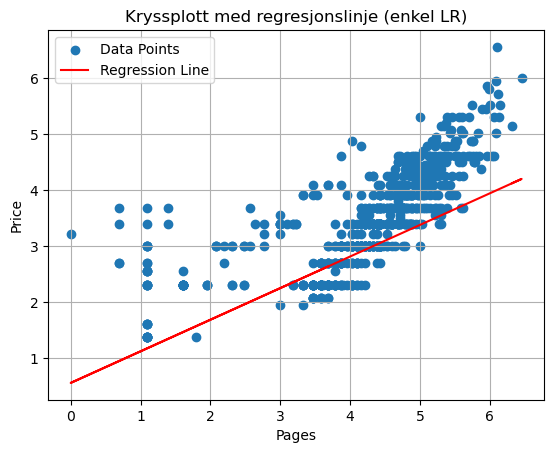

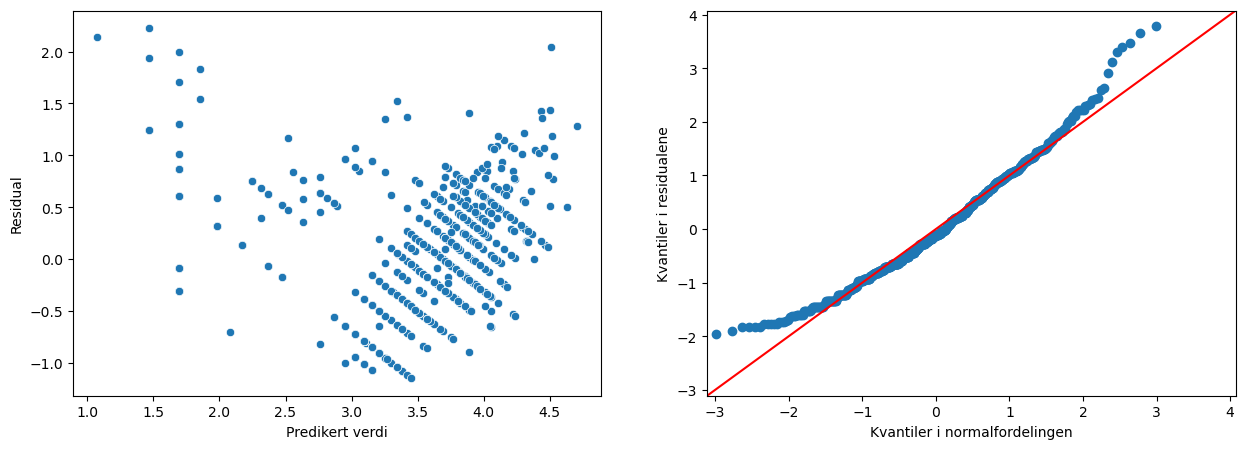

### Pieces

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     1898.
Date:                Fri, 17 Nov 2023   Prob (F-statistic):          4.88e-203
Time:                        19:59:23   Log-Likelihood:                -437.62
No. Observations:                 714   AIC:                             879.2
Df Residuals:                     712   BIC:                             888.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1894      0.085     -2.224      0.026      -0.357      -0.022
Pieces         0.6670      0.015     43.569      0.000       0.637       0.697
==============================================================================
Omnibus:                      136.683   Durbin-Watson:                   1.387
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              269.375
Skew:                           1.089   Prob(JB):                     3.21e-59
Kurtosis:                       5.075   Cond. No.                         29.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

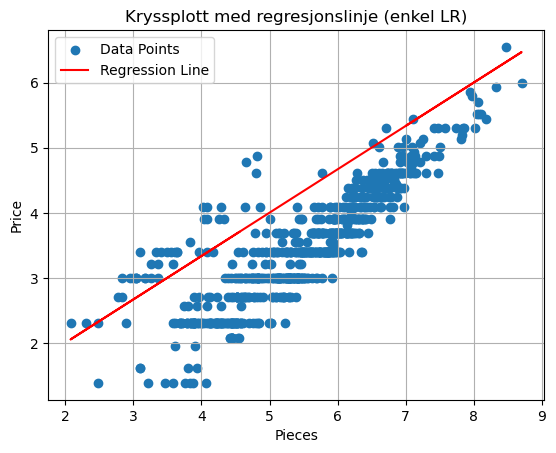

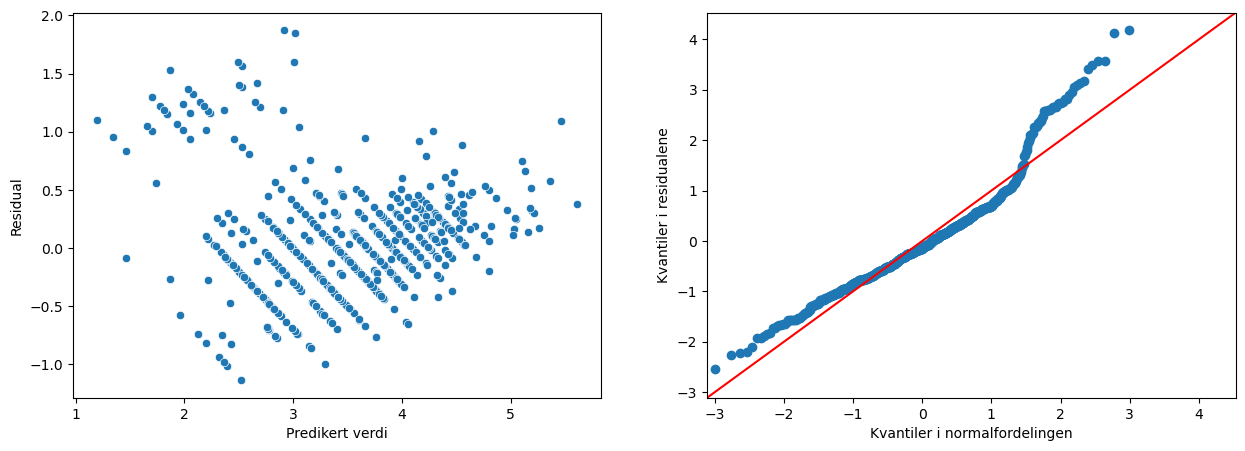

### Unique_Pieces

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     1722.
Date:                Fri, 17 Nov 2023   Prob (F-statistic):          3.16e-192
Time:                        19:59:23   Log-Likelihood:                -462.57
No. Observations:                 714   AIC:                             929.1
Df Residuals:                     712   BIC:                             938.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.6706      0.101     -6.657      0.000      -0.868      -0.473
Unique_Pieces     0.8813      0.021     41.498      0.000       0.840       0.923
==============================================================================
Omnibus:                      153.509   Durbin-Watson:                   1.332
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              306.027
Skew:                           1.212   Prob(JB):                     3.52e-67
Kurtosis:                       5.100   Cond. No.                         28.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

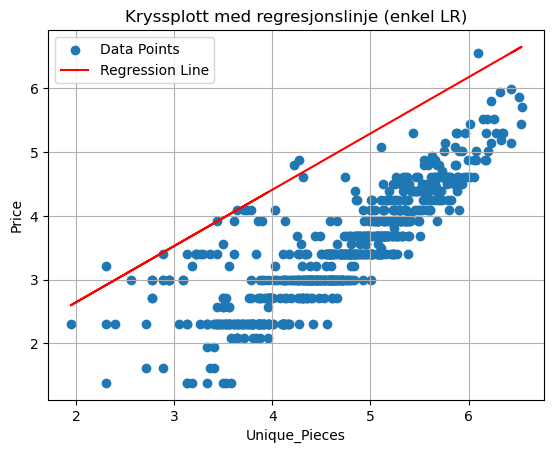

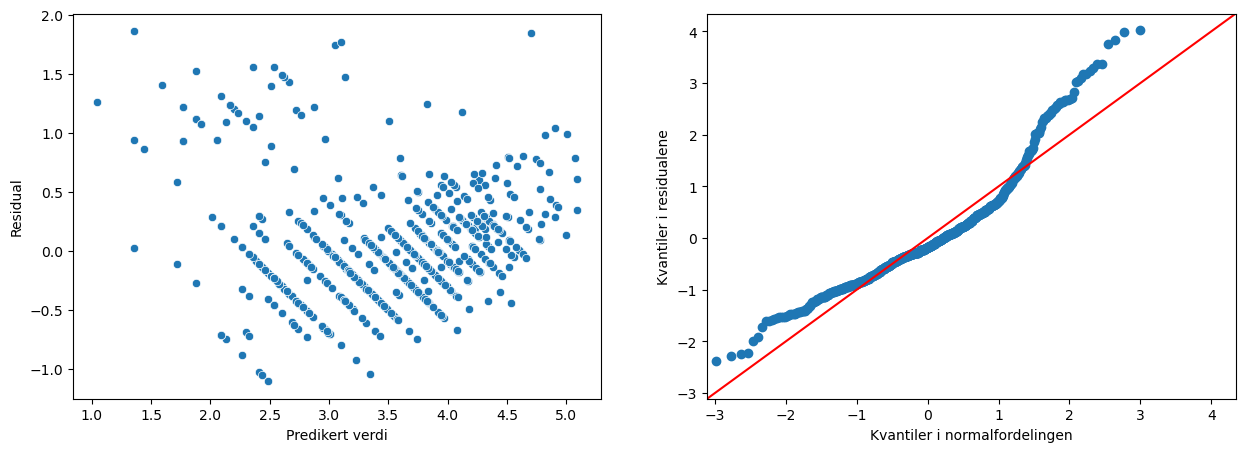

In [8]:

for field in ["Pages", "Pieces", "Unique_Pieces"]:
    model4a = smf.ols(f"Price ~ {field}", data = df2)
    fit = model4a.fit()

    display(Markdown(f"### {field}"))
    display(fit.summary())

    regression_x = np.array(df2[field])
    regression_y = fit.params[field] * regression_x + fit.params[field]
    
    plt.scatter(df2[field], df2['Price'], label='Data Points')
    plt.plot(regression_x, regression_y, color='red', label='Regression Line')
    plt.xlabel(field)
    plt.ylabel('Price')
    plt.title('Kryssplott med regresjonslinje (enkel LR)')
    plt.legend()
    plt.grid()
    plt.savefig(f"log-transformed-regression-{field}")
    plt.show()

    figure, axis = plt.subplots(1, 2, figsize = (15, 5))
    sns.scatterplot(x = fit.fittedvalues, y = fit.resid, ax = axis[0])
    axis[0].set_ylabel("Residual")
    axis[0].set_xlabel("Predikert verdi")
    
    sm.qqplot(fit.resid, line = '45', fit = True, ax = axis[1])
    axis[1].set_ylabel("Kvantiler i residualene")
    axis[1].set_xlabel("Kvantiler i normalfordelingen")
    plt.savefig(f"qq-plot-log-transformed-regression-{field}")
    plt.show()

Vi ser at QQ-plottene er mye bedre, og `Pieces` har den beste `Adj. R-squared`.
`Price ~ Pieces` er den beste modellen når man ikke tar hensyn til lisens.

Vi skal nå se om lisens har en påvirkning på pris.

In [9]:
# Lager dummy-variabler for hver av kategoriene under

licensed = {
    'Spider-Man', 'Powerpuff Girls', 'Minions', 'Stranger Things', 'Star Wars', 'Marvel', 'Disney', 'Harry Potter', 'Minecraft',
    'Jurassic World', 'Batman', 'DC', 'Trolls World Tour', 'Overwatch', 'LEGO Frozen 2'
}

not_licensed = {
    'Monkie Kid', 'Friends', 'City', 'NINJAGO', 'DUPLO', 'Creator 3-in-1', 'Hidden Side', 'Ideas', 'Classic', 'Powered UP'
}

uncertain = {
    'Unikitty', 'Minifigures', 'THE LEGO MOVIE 2', 'Speed Champions', 'Juniors', 'Creator Expert'
}

# verifiser at vi har fått med alle temaene i gruppene
#assert licensed|uncertain|not_licensed == set(df2['Theme'])

df2['Category'] = np.where(
    df2['Theme'].isin(
        licensed
    ),
    'licensed',
    np.where(
        df2['Theme'].isin(
            not_licensed
        ),
        'not_licensed',
        np.where(
            df2['Theme'].isin(
                uncertain   
            ),
            'uncertain',
            'unaccounted for'
        )
    )
)


## Generering og presentasjon av modell

In [13]:
model = smf.ols(f'Price ~ Pieces * Category' , data = df2)
fit   = model.fit()

with open('table.html', 'w') as f:
    table_html = fit.summary().tables[0].as_html()
    f.write(table_html)
    options = {
        'format': 'png',
        'width': 800,
    }
    imgkit.from_file('table.html', 'table.png', options=options)

display(result.summary())

plt.savefig('mlr-summary.png')
plt.show()
#display(fit.summary())

# Display linear regression
intercept = [fit.params['Category[T.not_licensed]'],        fit.params['Category[T.uncertain]'],        0] + fit.params['Intercept']
slope     = [fit.params['Pieces:Category[T.not_licensed]'], fit.params['Pieces:Category[T.uncertain]'], 0] + fit.params['Pieces']

for i, theme in enumerate([not_licensed, uncertain, licensed]):
    subset = df2[df2['Theme'].isin(theme)]
    regression_x = np.array(subset['Pieces'])
    regression_y = slope[i] * regression_x + intercept[i]

    # Plot scatter plot and regression line
    plt.scatter(subset['Pieces'], subset['Price'], color=plt.cm.tab10(i))
    plt.plot(regression_x, regression_y, color=plt.cm.tab10(i), label=theme)

# Display
display(Markdown('### Kryssplot'))
plt.show()

# QQ og residualplot
figure, axis = plt.subplots(1, 2, figsize = (15, 5))
sns.scatterplot(x = fit.fittedvalues, y = fit.resid, ax = axis[0])
axis[0].set_ylabel("Residual")
axis[0].set_xlabel("Predikert verdi")
sm.qqplot(fit.resid, line = '45', fit = True, ax = axis[1])
axis[1].set_ylabel("Kvantiler i residualene")
axis[1].set_xlabel("Kvantiler i normalfordelingen")

display(Markdown('### QQ og residualplot'))
plt.show()

NameError: name 'imgkit' is not defined

```
                                      coef  std err       t  P>|t|  [0.025  0.975]
Pieces:Category[T.not_licensed]    -0.0451    0.034  -1.342  0.180  -0.111  0.021
Pieces:Category[T.uncertain]        0.0868    0.051   1.698  0.090  -0.014  0.187
```
Vi ser at p-verdiene til `not_licensed` og `uncertain` ikke er gode nok til å forkaste nullhypotesen, vi kan derfor ikke si noe om hvorvidt lisens påvirker pris.

# 3. Initialisere og tilpasse modellen

# 4. Presentere resultater fra den tilpassede modellen

# 5. Evaluere om modellen passer til dataene